In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
import time
import csv
import scipy.stats as sc

Thrash particle initialized to get reference trajectory
Trajectory found, now initializing all the particles...
All particles are initialized in:  0.9413957595825195  Expected time for inference:  470.69787979125977
Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40
Iteration:  50
Iteration:  60
Iteration:  70
Iteration:  80
Iteration:  90
Iteration:  100
Iteration:  110
Iteration:  120
Iteration:  130
Iteration:  140
Iteration:  150
Iteration:  160
Iteration:  170
Iteration:  180
Iteration:  190
Iteration:  200
Iteration:  210
Iteration:  220
Iteration:  230
Iteration:  240
Iteration:  250
Iteration:  260
Iteration:  270
Iteration:  280
Iteration:  290
Iteration:  300
Iteration:  310
Iteration:  320
Iteration:  330
Iteration:  340
Iteration:  350
Iteration:  360
Iteration:  370
Iteration:  380
Iteration:  390
Iteration:  400
Iteration:  410
Iteration:  420
Iteration:  430
Iteration:  440
Iteration:  450
Iteration:  460
Iteration:  470
Iteration:  480
Iteration: 

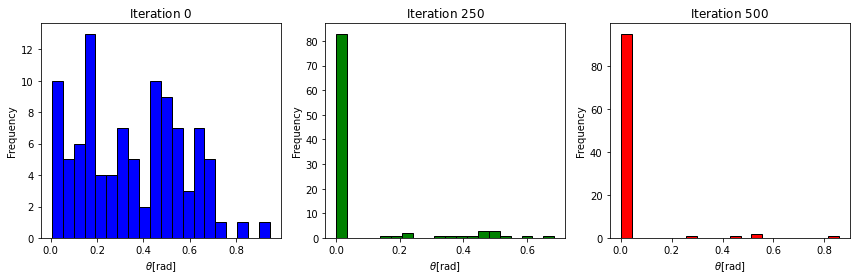

ValueError: supplied range of [-inf, -50822573.65371278] is not finite

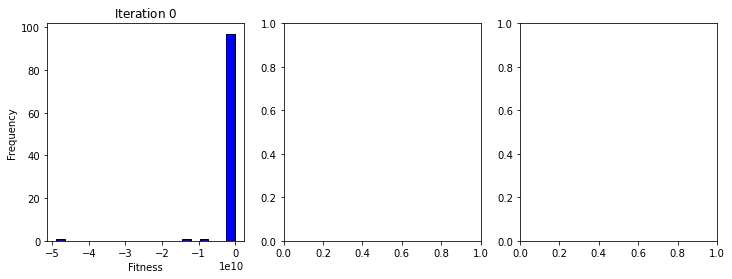

In [25]:
##FINAL VERSION WITH FITNESS FUNCTION NOT COMPUTED EVRY TIME
data_size = 100

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity,id, dimension, x_ref):
        # Necessary for all the particles iincluding thrash one
        self.dt = 0.025
        self.commands = get_folder_path()+'/open_loop_inputs/open_loop_commands.csv'
        self.N = get_csv_row_count(self.commands)
        self.open_loop_tf = self.N*self.dt

        dt = 0.05
        open_loop_tf = 10000
        T_peak = 0.37
        T_slope = 0.4
        

        self.model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)

        if id != 9999999999: # Avoid constructor for  thrash particle
            self.position = position
            self.velocity = velocity
            self.best_position = position.copy()
            self.dimension = dimension

            #related to vehicle model
            self.param_to_infer = 2
            self.x_scal_ref = x_ref
            self.x_vect_ref = x_ref
            self.model = None
            # T_peak and T_slope is not specified since we infer those
            self.id = id

            
            self.position_cost_value = self.compute_fitness_function()
            self.best_position_cost_value = float(self.position_cost_value)


    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position.copy()
            self.best_position_cost_value = self.position_cost_value
    
    def compute_fitness_function(self):
        return float(self.get_kpi())
    
    def get_kpi(self):
        return self.lhd()
        #return (self.model4.kinematik_model_radius(self.position)-self.get_x_scal_ref())**2 #for dirac
    
    def get_x_scal_ref(self):
        return self.model4.kinematik_model_radius(0.1)
    
    def get_x_vect_ref(self):
        
        steering = np.full(data_size,0.1)

        for i in range(len(steering)):
            steering[i] += np.random.normal(0,0.005)

        # obtain response and add noise
        y_likelihood = np.zeros(data_size)
        for i in range(len(steering)):
            y_likelihood[i] = self.model4.kinematik_model_radius(steering[i])
        y_likelihood.reshape(-1,1)  
        
        return y_likelihood
    
    def lhd(self):
        # x is the data matrix, first column for input and second column for output.
        # theta is a vector containing the parameters for the evaluation
        # remember theta[0] is a, theta[1] is b and theta[2] is sigma
        
        proposed_radius = self.model4.kinematik_model_radius(self.position)
        mean = np.full(self.x_vect_ref.shape[0], proposed_radius).reshape(-1,1)
        
        
        lhd_out = sc.norm.logpdf(self.x_vect_ref, loc= mean, scale= 0.1)
        

        #print("np.full",end_time1-start_time1)
        #print("lhdout",end_time2-end_time1)
        
        # then we sum lhd_out (be careful here, we are summing instead of multiplying
        # because we are dealing with the log-likelihood, instead of the raw likelihood).
        lhd_out = np.sum(lhd_out)
        return lhd_out
            
    




class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.global_best_position_cost = None


        self.particle_positions_history = []
        self.particle_fitness_history = []




    #------------------OPTIMIZATION------------------#

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()

            self.update_global_best_position()
            if iter%10 == 0:
                print('Iteration: ', iter)

    def initialize_particles(self):
        self.particles = []
        
        
        # Thrash particle to get the right value of x_ref
        print('Thrash particle initialized to get reference trajectory')
        thash_id = 9999999999
        thrash_particle = Particle(None, None, thash_id, None, None )
        x_ref = thrash_particle.get_x_vect_ref() # get_x_scal_ref() for not likelihood
        print('Trajectory found, now initializing all the particles...')
        t_before = time.time()
        for i in range(self.num_particles):
            
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            id = i
            dimension = self.dimension
            particle = Particle(position, velocity, id, dimension, x_ref)
            self.particles.append(particle)
        t_after = time.time()
        elapsed_time = t_after-t_before
        print('All particles are initialized in: ', elapsed_time, ' Expected time for inference: ', elapsed_time*self.max_iterations)
        

        index_best_initial_particle = np.argmin([ particle.position_cost_value for particle in self.particles])
        self.global_best_position = self.particles[index_best_initial_particle].position.copy()
        self.global_best_position_cost = self.particles[index_best_initial_particle].position_cost_value

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_cost:
                self.global_best_position = particle.position.copy()
                self.global_best_position_cost = particle.position_cost_value


    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel(r'Fitness')
        ax1.set_ylabel(r'Frequency')
        ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel(r'Fitness')
        ax2.set_ylabel(r'Frequency')
        ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel(r'Fitness')
        ax3.set_ylabel(r'Frequency')
        ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

        plt.tight_layout()
        plt.show()


    def plot_particle_history(self):
        if self.dimension == 1:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

            # Plot histogram at the start
            ax1.hist(self.particle_positions_history[0], bins=20, color='blue', edgecolor='black')
            ax1.set_xlabel(r'$\theta \rm [rad]$')
            ax1.set_ylabel(r'Frequency')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist(self.particle_positions_history[middle_index], bins=20, color='green', edgecolor='black')
            ax2.set_xlabel(r'$\theta \rm [rad]$')
            ax2.set_ylabel(r'Frequency')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist(self.particle_positions_history[-1], bins=20, color='red', edgecolor='black')
            ax3.set_xlabel(r'$\theta \rm [rad]$')
            ax3.set_ylabel(r'Frequency')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()


        if self.dimension == 2:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            # Plot histogram at the start
            ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
            ax1.set_xlabel(r'$T_{peak}$')
            ax1.set_ylabel(r'$T_{front}$')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
            ax2.set_xlabel(r'$T_{peak}$')
            ax2.set_ylabel(r'$T_{front}$')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
            ax3.set_xlabel(r'$T_{peak}$')
            ax3.set_ylabel(r'$T_{front}$')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()

    def save_to_csv(self, path):
        iteration = self.max_iterations
        num_particles = self.num_particles
        particles_positions = self.particle_positions_history.reshape(-1,2)

        # Define the CSV file path
        csv_file = path

        # Write data to CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['T_peak', 'T_front', 'Iteration', 'Particles'])
            writer.writerow([particles_positions[0, 0], particles_positions[0, 1], iteration, num_particles])
            writer.writerows(particles_positions[1:])

        print(f"Data saved to {csv_file}.")


# Example usage
upper_bouds_1d = 1
lower_bouds_1d = 0
upper_bouds_2d = [1,1]
lower_bouds_2d = [0,0]
pso = PSO(num_particles=100, max_iterations=500, lower_bounds=lower_bouds_1d, upper_bounds=upper_bouds_1d, dimension=1)


pso.optimize()
pso.plot_particle_history()
pso.plot_particle_fitness_history()
#pso.save_to_csv('./Results/PSO/iter50particle10.csv')



In [15]:
particle_positions_history_mean = []
for i in range(len(pso.particle_positions_history)):
    mean = 0
    for j in range(pso.particle_positions_history[i].shape[0]):
        mean += pso.particle_positions_history[i][j][0]/pso.particle_positions_history[i].shape[0]
    particle_positions_history_mean.append(mean)


Text(0, 0.5, 'Fitness')

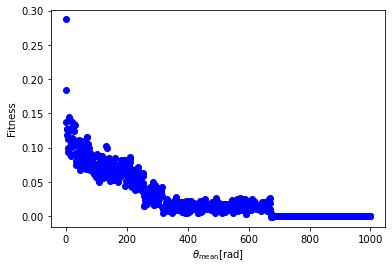

In [16]:
x = np.arange(0,len(particle_positions_history_mean),1)
plt.scatter(x, particle_positions_history_mean, color = 'blue')
plt.xlabel("steering")
plt.xlabel(r"$ \theta_{\rm mean} \rm [rad]$")
plt.ylabel(r"Fitness")

In [5]:
pso.particle_positions_history[0][0][0]

0.3747873777380971

In [22]:
pso.particle_positions_history[len(pso.particle_positions_history)-1]

array([[-2.79415220e-06],
       [ 3.03699289e-01],
       [-1.59247341e-30],
       [-9.79988670e-29],
       [ 2.02845784e-01],
       [-7.16740435e-31],
       [-1.10085860e-25],
       [ 3.28309937e-01],
       [-6.66768399e-28],
       [-2.91954501e-29],
       [-6.74116444e-31],
       [-1.84659307e-30],
       [-9.94913333e-31],
       [ 3.32563224e-01],
       [-4.37287479e-03],
       [-2.60031698e-31],
       [-4.02838473e-31],
       [-3.10613085e-24],
       [-5.24507084e-31],
       [-5.24759677e-11]])